In [36]:
import pandas as pd
import numpy as np
import datetime
from haversine import haversine
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import folium
import webbrowser
from tqdm import tqdm

%matplotlib inline

# 1 Data Load

In [2]:
df = pd.read_csv('event_sample.csv', sep=';', header=None, 
                 names=['id', 'timestamp', 'lon', 'lat'], parse_dates=[1])
df.head()

id                 timestamp         lon        lat
0   2 2017-03-20 00:00:18+03:00   38.937878  47.210758
1   3 2017-03-20 00:00:18+03:00   45.655278  43.259605
2   4 2017-03-20 00:00:18+03:00   47.113440  42.804970
3   5 2017-03-20 00:00:18+03:00  158.601667  53.068436
4   6 2017-03-20 00:00:18+03:00  104.259995  52.250453

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727040 entries, 0 to 1727039
Data columns (total 4 columns):
 #   Column     Dtype                                
---  ------     -----                                
 0   id         int64                                
 1   timestamp  datetime64[ns, pytz.FixedOffset(180)]
 2   lon        float64                              
 3   lat        float64                              
dtypes: datetime64[ns, pytz.FixedOffset(180)](1), float64(2), int64(1)
memory usage: 52.7 MB


In [4]:
df.describe()

id           lon           lat
count  1.727040e+06  1.727040e+06  1.727040e+06
mean   5.333336e+02  4.920323e+01  4.923244e+01
std    2.867934e+02  2.364038e+01  5.652681e+00
min    2.000000e+00  2.039901e+01  2.100000e+01
25%    2.720000e+02  3.919314e+01  4.334113e+01
50%    6.250000e+02  4.196243e+01  4.742293e+01
75%    7.980000e+02  4.585892e+01  5.464048e+01
max    9.740000e+02  1.777558e+02  6.956465e+01

In [5]:
df.isna().sum()

id           0
timestamp    0
lon          0
lat          0
dtype: int64

### По крайней мере, нет пропусков - уже проще))

# 2 Несколько траекторий и рассуждения
Данные, по всей видимости, получены с вышек сотовой связи. Крайне высокий шум и пользователь очень часто скачет между 3-мя точками. Также, встречаются артефакты - пользователь "прыгает" на несколько десятков километров в соседних измерениях. Пользователи совершенно разные - я, помимо обычных работников, нашел домоседов, путешественников в ОАЭ и чуть менее теплые места, водителей автобусов и просто людей, метнувшихся в соседний город.

In [40]:
#Trip to Unated Arab Emirates ID=85
data = df[df.id == 85].to_dict(orient='list')
m = folium.Map(location=(data['lat'][0], data['lon'][0]), zoom_start=2)
for i in range(len(data['lat'])):
    folium.Marker(location=(data['lat'][i], data['lon'][i])).add_to(m)
m

In [41]:
#Bus between metro Yuzhnaya & Shcherbinka ID=128
data = df[df.id == 128].to_dict(orient='list')
m = folium.Map(location=(data['lat'][0], data['lon'][0]), zoom_start=10)
for i in range(len(data['lat'])):
    folium.Marker(location=(data['lat'][i], data['lon'][i])).add_to(m)
m

In [42]:
#Truck in Yaroslavl ID=67
data = df[df.id == 67].to_dict(orient='list')
m = folium.Map(location=(data['lat'][0], data['lon'][0]), zoom_start=10)
for i in range(len(data['lat'])):
    folium.Marker(location=(data['lat'][i], data['lon'][i])).add_to(m)
m

In [43]:
#Guy who spent whole day in one place but with huge noise ID=10
data = df[df.id == 10].to_dict(orient='list')
m = folium.Map(location=(data['lat'][0], data['lon'][0]), zoom_start=13)
for i in range(len(data['lat'])):
    folium.Marker(location=(data['lat'][i], data['lon'][i])).add_to(m)
m

In [44]:
#Started from home and no return ID=821
data = df[df.id ==821].to_dict(orient='list')
m = folium.Map(location=(data['lat'][0], data['lon'][0]), zoom_start=12)
for i in range(len(data['lat'])):
    folium.Marker(location=(data['lat'][i], data['lon'][i])).add_to(m)
m

In [45]:
#My favorite example - man from Krasnodar, who can teleport :) ID=617
data = df[df.id == 617].to_dict(orient='list')
m = folium.Map(location=(data['lat'][0], data['lon'][0]), zoom_start=9)
for i in range(len(data['lat'])):
    folium.Marker(location=(data['lat'][i], data['lon'][i])).add_to(m)
m

In [46]:
#Ordinary guy ID=256
data = df[df.id == 256].to_dict(orient='list')
m = folium.Map(location=(data['lat'][0], data['lon'][0]), zoom_start=13)
for i in range(len(data['lat'])):
    folium.Marker(location=(data['lat'][i], data['lon'][i])).add_to(m)
m

Все данные относятся к одному дню - 20-е марта 2017 года (понедельник), есть 21 запись за 21-е число. Поэтому полнота анализа страдает, может офисного работника отправили в командировку или у него выходной. При анализе использовались следующие допущения:
- человек, посещающий работу не может проехать более 300 км за день (диагональ покрывающего прямоугольника меньше 150 км)
- скорость передвижения - не более 30 м/с (108 км/ч) - это необходимо для фильтрации шума. В городе быстрее не разогнаться (по крайней мере, на длительное время), а высокоскоростные поезда и самолеты мы отфильтруем на предыдущем этапе
- работой или домом может считаться место, в котором человек провел не менее 4-х часов
- первое измерение и последнее измерение должно относиться к одному кластеру

Предсказывать будем 1, если человек работает и 0 в противном случае.

Алгоритм работы следующий:
1) Для тех, у кого диагональ прямоугольника больше 150 км или меньше 25 точек предсказываем 0
2) Фильтруем шумы по скорости передвижений
3) Усредняем плавающим окном по 5-ти зачениям
4) Запускаем DBSCAN с параметром eps, зависящим от разброса координат (diagonal / 15)
5) По полученным кластерам считаем время пербывания и их размер
6) Проверяем длительность пребывания, размер кластера и совпадение начальной и конечной координат
7) выдаем ответ

# 3 Implementation

In [15]:
def get_cluster_len(cluster, full_output=False):
    min_lat = min(cluster['lat'])
    max_lat = max(cluster['lat'])
    min_lon = min(cluster['lon'])
    max_lon = max(cluster['lon'])
    if full_output:
        return haversine((min_lat, min_lon), (max_lat, max_lon), unit='m'), min_lon, max_lon, min_lat, max_lat
    else:
        return haversine((min_lat, min_lon), (max_lat, max_lon), unit='m')

def get_distance_matrix(data_dict):
    n_samples = len(data_dict['lat'])
    result = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            distance = haversine((data_dict['lat'][i], data_dict['lon'][i]),
                                 (data_dict['lat'][j], data_dict['lon'][j]), unit='m')
            result[i][j] = distance
            result[j][i] = distance
    return result

def moving_average(x, w=5):
    x = [x[0]] * (w - 1) + x #add padding
    return (np.convolve(x, np.ones(w), mode='full') / w)[w-1:-w+1]

ROUND_DIG = 3
def apply_speed_filter(data_dict, speed_limit):
    '''Applyes speed filter by removing points which we reached too fast.
    Those points are replaced with previous value.
    Input data must be dict with 3 lists: timestamp, lon, lat. Output has same format'''
    result = {'timestamp': [], 'lon': [], 'lat': []}
    result['timestamp'].append(data_dict['timestamp'][0])
    result['lon'].append(round(data_dict['lon'][0], ROUND_DIG))
    result['lat'].append(round(data_dict['lat'][0], ROUND_DIG))
    #Adding twice to keep initial time
    result['timestamp'].append(data_dict['timestamp'][0])
    result['lon'].append(round(data_dict['lon'][0], ROUND_DIG))
    result['lat'].append(round(data_dict['lat'][0], ROUND_DIG))
    
    for i in range(1, len(data_dict['lon'])):
        distance = haversine((result['lat'][-1], result['lon'][-1]),
                            (round(data_dict['lat'][i], ROUND_DIG),
                             round(data_dict['lon'][i], ROUND_DIG)), unit='m')
        time = (data_dict['timestamp'][i] - result['timestamp'][-1]).seconds

        if time > 0 and distance > 1e-3 and distance / time < speed_limit:
            result['timestamp'].append(data_dict['timestamp'][i])
            result['lon'].append(round(data_dict['lon'][i], ROUND_DIG))
            result['lat'].append(round(data_dict['lat'][i], ROUND_DIG))
        else:
            result['timestamp'][-1] = data_dict['timestamp'][i]
    return result

def get_clusters(data_dict, labels):
    result = {}
    current_time = data_dict['timestamp'][0]
    for i, l in enumerate(labels):
        if l < 0: #not in cluster
            current_time = data_dict['timestamp'][i]
            continue
        if l not in result.keys():
            result[l] = {
                'id': l,
                'total_time': 0,
                'lon': [],
                'lat': []
            }
        result[l]['total_time'] += (data_dict['timestamp'][i] - current_time).seconds
        current_time = data_dict['timestamp'][i]
        result[l]['lon'].append(data_dict['lon'][i])
        result[l]['lat'].append(data_dict['lat'][i])
    return result

In [20]:
#Main function
MAX_SPEED=30
MIN_SAMPLES = 25
MAX_DISTANCE = 150000 #150 km - more than 300km for day trip - not a worker
MIN_WORK_TIME = 4 * 3600 #if less time - not a worker

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'black']

def process_df(df, show_on_map=False, filename=None):
    '''If you want visualization you can set show_on_map to `plt` or `folium`.
    PLT will do simple plotting, FOLIUM will open another tab in browser wit interacive map.
    To save file just specify filename'''
    #Predict 0 for small DF
    if len(df) < MIN_SAMPLES:
        return 0
    #Predict 0 for long distance
    df_diag = get_cluster_len(df)
    if df_diag > MAX_DISTANCE:
        return 0
    filtered = apply_speed_filter(df.sort_values('timestamp').to_dict(orient='list'), MAX_SPEED)
    #adding moving average
    filtered['lat'] = moving_average(filtered['lat'])
    filtered['lon'] = moving_average(filtered['lon'])
    dist_matrix = get_distance_matrix(filtered)
    max_distance = np.max(dist_matrix)
    clustering = DBSCAN(eps=max_distance / 15, metric='precomputed', min_samples=7)
    clustering.fit(dist_matrix)
    result = get_clusters(filtered, clustering.labels_)
    
    if show_on_map == 'folium':
        start_point = (filtered['lat'][0], filtered['lon'][0])
        m = folium.Map(location=start_point, zoom_start=11)
        for i in range(len(filtered['lat'])):
            folium.CircleMarker((filtered['lat'][i], filtered['lon'][i]), 
                                radius=1, color=colors[clustering.labels_[i]]).add_to(m)
        m.save('map.html')
        webbrowser.open('map.html')
    elif show_on_map == 'plt':
        plt.scatter(filtered['lon'], filtered['lat'], c=clustering.labels_)
        plt.show()
    if filename != None:
        save_df = pd.DataFrame.from_dict(filtered)
        save_df.to_csv(filename, sep=';', header=None, index=None, columns=['timestamp', 'lon', 'lat'])
    
    #Only 1 cluster
    if 1 not in clustering.labels_:
        return 0
    #Must be at home at midnight
    if clustering.labels_[0] < 0 or clustering.labels_[-1] != clustering.labels_[0]:
        return 0
    cluster_info = []
    for c in result.values():
        cluster_info.append((c['total_time'], get_cluster_len(c), c['id']))
    cluster_info = sorted(cluster_info, reverse=True)
    
    #Too few time in second cluster
    if cluster_info[1][0] < MIN_WORK_TIME:
        return 0
    #Too big first o second clusters
    if cluster_info[0][1] > max_distance * 0.3 or cluster_info[1][1] > max_distance * 0.3:
        return 0
    return 1

# 4 Test predictions for IDs 128, 67, 10, 821, 617, 256
If you like, you can set show_on_map='folium' and get interactive map in new tab

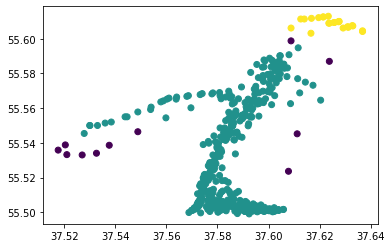

In [24]:
answer = process_df(df[df.id == 128], show_on_map='plt', filename='128.csv')

In [25]:
answer

0

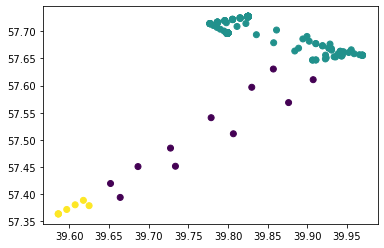

In [26]:
answer = process_df(df[df.id == 67], show_on_map='plt', filename='67.csv')

In [27]:
answer

0

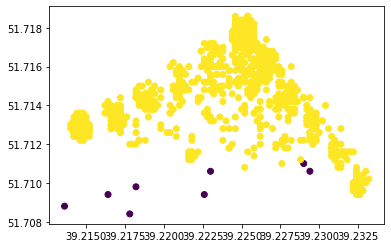

In [28]:
answer = process_df(df[df.id == 10], show_on_map='plt', filename='10.csv')

In [29]:
answer

0

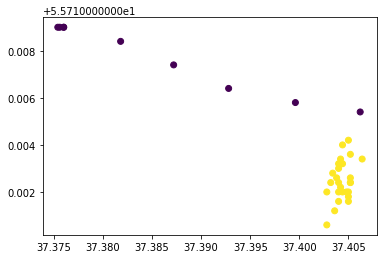

In [30]:
answer = process_df(df[df.id == 821], show_on_map='plt', filename='821.csv')

In [31]:
answer

0

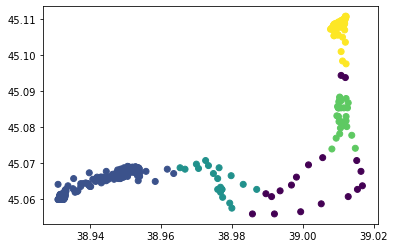

In [32]:
answer = process_df(df[df.id == 617], show_on_map='plt', filename='617.csv')

In [33]:
answer

0

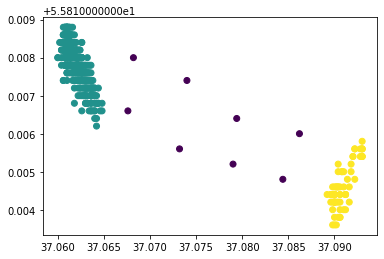

In [34]:
answer = process_df(df[df.id == 256], show_on_map='plt', filename='256.csv')

In [35]:
answer

1

# 5 Predict everything

In [38]:
answers = {}
for cur_id in tqdm(df.id.unique()):
    answer = process_df(df[df.id == cur_id])
    answers[cur_id] = answer

100%|██████████| 973/973 [19:31<00:00,  1.20s/it]  


In [39]:
with open('submission.csv', 'w') as f:
    for i, a in answers.items():
        f.write(f'{i},{a}\n')